# 1. Describe the data
- It has 1001 observations.
- There are 10 variables:
    - nhtemp: Northern Hemisphere temperature anomaly, representing the deviation from a long-term average.
    - wusa: Western USA temperature anomaly, indicating the temperature deviation for the Western United States.
    - jasper: Jasper temperature anomaly, showing the temperature deviation for the Jasper region.
    - westgreen: Western Greenland temperature anomaly, representing the temperature deviation for Western Greenland.
    - chesapeake: Chesapeake temperature anomaly, indicating the temperature deviation for the Chesapeake region.
    - tornetrask: Torneträsk temperature anomaly, showing the temperature deviation for the Torneträsk region.
    - urals: Urals temperature anomaly, representing the temperature deviation for the Urals region.
    - mongolia: Mongolia temperature anomaly, indicating the temperature deviation for Mongolia.
    - tasman: Tasman temperature anomaly, showing the temperature deviation for the Tasman region.
    - year: The year of the observation, representing the specific year for which the temperature anomalies are recorded.
- Temperature anomalies are usually measured in degrees Celsius (°C).
- Reliable thermometer records of annual temperatures only go back to the 1850s. To estimate temperatures before this period, we can use proxies like tree rings. By building a linear model to predict temperatures from 1856 onwards, we can then use this model to estimate earlier temperatures based on proxy data. The data used here is derived from Jones and Mann (2004). Faraway have selected proxies with mostly complete data, imputed some missing values, and applied smoothing for demonstration purposes. We start by fitting a model with temperature as the response variable and the eight proxies as predictors.
- There are missing values for nhtemp prior to 1856. In the package statsmodels, the default behavior when performing a regression with missing values is to omit any case that contains a missing value. Therefore, this model uses only data from 1856 through 2000.

# 2. Load package and data

In [1]:
%%capture
pip install faraway

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import faraway.utils

In [4]:
import faraway.datasets.globwarm
globwarm_df = faraway.datasets.globwarm.load()
globwarm_df.head()

,nhtemp,wusa,jasper,westgreen,chesapeake,tornetrask,urals,mongolia,tasman,year
0,NaN,-0.66,-0.03,0.03,-0.66,0.33,-1.49,0.83,-0.12,1000
1,NaN,-0.63,-0.07,0.09,-0.67,0.21,-1.44,0.96,-0.17,1001
2,NaN,-0.60,-0.11,0.18,-0.67,0.13,-1.39,0.99,-0.22,1002
3,NaN,-0.55,-0.14,0.30,-0.68,0.08,-1.34,0.95,-0.26,1003
4,NaN,-0.51,-0.15,0.41,-0.68,0.06,-1.30,0.87,-0.31,1004


# 3. Linear regression

In [5]:
lmod = smf.ols('nhtemp ~ wusa + jasper + westgreen + chesapeake + \
        tornetrask + urals + mongolia + tasman', globwarm_df).fit()
lmod.sumary()

            coefs stderr tvalues pvalues
Intercept  -0.243  0.027   -8.98  0.0000
wusa        0.077  0.043    1.80  0.0736
jasper     -0.229  0.078   -2.93  0.0040
westgreen   0.010  0.042    0.23  0.8192
chesapeake -0.032  0.034   -0.94  0.3473
tornetrask  0.093  0.045    2.06  0.0416
urals       0.185  0.091    2.03  0.0446
mongolia    0.042  0.046    0.92  0.3610
tasman      0.115  0.030    3.83  0.0002

n=145 p=9 Residual SD=0.176 R-squared=0.48


# 4. Diagnosis

## 4.1. Correlated errors
- To analyze correlated errors in temporal data, it’s common to plot the residuals against the time index. This visual approach helps identify any patterns or trends in the errors over time. If the errors are not correlated, the points should be randomly scattered above and below the zero-error line.

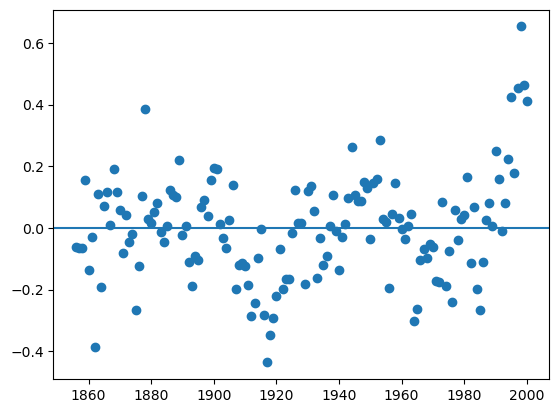

In [8]:
plt.scatter(globwarm.year[lmod.resid.keys()], lmod.resid); plt.axhline(0);

- In this plot, we see long sequences of points above or below the line. This is an indication of positive serial correlation.
- Another method to check for serial correlation is to plot the residuals of successive pairs. If we suspect a more complex dependence, we can plot more than just successive pairs.

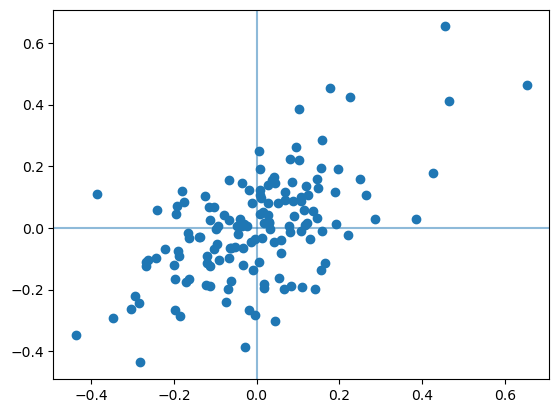

In [10]:
plt.scatter(lmod.resid.iloc[:-1], lmod.resid.iloc[1:])
plt.axhline(0, alpha=0.5); plt.axvline(0, alpha=0.5);

- We can see a positive correlation again indicating positive serial correlation.
- The Durbin–Watson test is used to assess the significance of correlation in errors. The null hypothesis states that the errors are uncorrelated. Under this assumption, the null distribution follows a linear combination of χ² distributions.
    - $DW = \frac{\sum_{i=2}^{n}{(\hat{ε}_i - \hat{ε}_{i-1})^2} }{\sum_{i=1}^{n}{\hat{ε}_i^2}}$
    - Under the null hypothesis, a test statistic value of 2 is expected. A value less than 1 indicates a potential issue.

In [11]:
sm.stats.stattools.durbin_watson(lmod.resid)

0.8166063726402727

- We see that the errors are correlated.
- We don’t expect the proxies to model temperature perfectly, and higher or lower temperatures in one year might influence the next year.
- Serial correlation can sometimes result from missing covariates in the model. For instance, if there’s a quadratic relationship between a predictor and the response, but only a linear term is included, diagnostics might show serial correlation in the residuals. In such cases, the missing quadratic term is the actual source of the problem, and including it in the model can help address the serial correlation.

In [8]:
# Calculate the correlation between the residual vector, first excluding the initial term 
# and then excluding the final term.
np.corrcoef(lmod.resid.iloc[:-1] ,lmod.resid.iloc[1:]).round(3)

array([[1.   , 0.583],
       [0.583, 1.   ]])

In [10]:
# Other way to calculate the correlation
lmod.resid.autocorr()

0.5833389850124189

# 5. Autoregressive model
$$ ε_{i+1} = ϕε_i + δ_i $ where $δ_i \sim N(0, τ^2 )$$

In [11]:
X = lmod.model.wexog
y = lmod.model.wendog
gmod = sm.GLSAR(y, X, rho=1)
res = gmod.iterative_fit(maxiter=6)
gmod.rho.round(3)

array([0.582])

- The estimated value of p closely matches the calculation of the OLS residuals.

In [15]:
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-0.2315,0.050,-4.658,0.000,-0.330,-0.133
x1,0.0634,0.077,0.823,0.412,-0.089,0.216
x2,-0.2120,0.143,-1.488,0.139,-0.494,0.070
x3,0.0066,0.072,0.092,0.927,-0.136,0.149
x4,-0.0144,0.058,-0.247,0.805,-0.130,0.101
x5,0.0577,0.076,0.760,0.448,-0.092,0.208
x6,0.2321,0.170,1.366,0.174,-0.104,0.568
x7,0.0490,0.082,0.596,0.552,-0.114,0.212
x8,0.1249,0.055,2.266,0.025,0.016,0.234


- The standard errors of $\hat{β}$ are significantly larger, and only one predictor is statistically significant in the output. However, due to substantial collinearity among the predictors, this should not be interpreted as indicating ‘no predictor effect.’
- It’s important to understand that correlation between predictors and correlation between errors are distinct phenomena with no necessary link between them. Significant autocorrelation is expected in this example because the proxies can only partially predict the temperature, leading to a natural carryover effect from one year to the next.

- Correlation between errors can also be expected when observations are grouped. In spatial data, for example, the relative locations of observations can model error correlation.
- Sometimes, correlation between errors is suspected without a clear structure to suggest a parameterized form, such as serial correlation or compound symmetry. The challenge is that there are too many pairwise correlations to estimate and insufficient data to do so.
    - In some cases, errors in observations might be correlated. For example, in an experiment comparing eight oat varieties, the growing area was divided into five blocks, with each variety planted once per block. The yield was recorded in grams per 16-ft row. It’s reasonable to expect correlated errors within each block, meaning errors for observations in the same block might be related. Errors for observations in different blocks are assumed to be uncorrelated. This is known as the compound symmetry assumption.